In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from hit_finding.constants import *
from hit_finding.metrics import *

# Compare Hits Reproduction

In [5]:
zscores = extract_scores_from_all(extract_score, threshold=4)
joined = pd.concat(zscores.values())
joined.shape

...................................

(11197, 18)

In [6]:
joined.columns

Index(['AGP_map', 'DNA_map', 'ER_map', 'Mito_map', 'RNA_map', 'ALL_map',
       'AGP_raw', 'DNA_raw', 'ER_raw', 'Mito_raw', 'RNA_raw', 'ALL_raw',
       'AGP_raw1to1', 'DNA_raw1to1', 'ER_raw1to1', 'Mito_raw1to1',
       'RNA_raw1to1', 'ALL_raw1to1'],
      dtype='object')

In [7]:
from reproducibility.ReproducibilityContext import ReproducibilityContext
from reproducibility.ReproducibilityStrategy import *
from reproducibility.FilterStrategy import *

In [8]:
from tqdm.notebook import tqdm

In [9]:
import joblib

In [12]:
rep_cont = ReproducibilityContext(None, None)
topk_filter=10
filter_strg = TopKFilterStrategy(topk_filter)
rep_strg = MeanDistanceStrategy()
rep_cont.filter_strategy = filter_strg
rep_cont.reproducibility_strategy = rep_strg
method='map'
cur = joined.filter(regex=f'_{method}')

cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')

In [13]:
rep_cont.filter_strategy.get_filter_threshold()

0.785024154589372

In [ ]:
rep_cont = ReproducibilityContext(None, None)
res = dict()
for method in ['map', 'raw']:
    res[method] = dict()
    cur = joined.filter(regex=f'_{method}$')

    res[method]['abs'] = dict()
    for rep_name in ['mean', 'chan_vector']:
            res[method]['abs'][rep_name] = []
            
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
            
    res[method]['topk'] = dict()
    for rep_name in ['mean', 'chan_vector']:
        res[method]['topk'][rep_name] = []
        
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topk'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_6797/311177651.py:17: RuntimeWarning: invalid value encountered in double_scalars
  metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()


  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}$')
            
    res[method]['abs']['uniqueness'] = []      
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['uniqueness'], [UniquenessStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            metric = rep_cont.dataframe_measure(cur, f'ALL_{method}')
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
    
    filter_dict = {
        'topk': TopKFilterStrategy,
        'topkfdup': TopKFromDupFilterStrategy,
        'topkfdupwmch': TopKFromDupWithMatchFilterStrategy
    }
    
    for k in filter_dict.keys():
        if k not in res[method].keys():
            res[method][k] = dict()
    
    for filter_name, filter_cls in filter_dict.items():
        res[method][filter_name]['uniqueness'] = []
        for topk_filter in tqdm(range(50, 1001, 50)):
            filter_strg = filter_cls(topk_filter)
            for rep_name, rep_strg in zip(['uniqueness'], [UniquenessStrategy()]):
                rep_cont.filter_strategy = filter_strg
                rep_cont.reproducibility_strategy = rep_strg
                metric = rep_cont.dataframe_measure(cur, f'ALL_{method}')
                res[method][filter_name][rep_name].append((topk_filter, metric))
                joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}$')
    
    res[method]['topkfdup']['chan_vector'] = []
    res[method]['topkfdup']['mean'] = []
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFromDupFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topkfdup'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

    res[method]['topkfdupwmch']['chan_vector'] = []
    res[method]['topkfdupwmch']['mean'] = []
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFromDupWithMatchFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topkfdupwmch'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/20 [00:00<?, ?it/s]

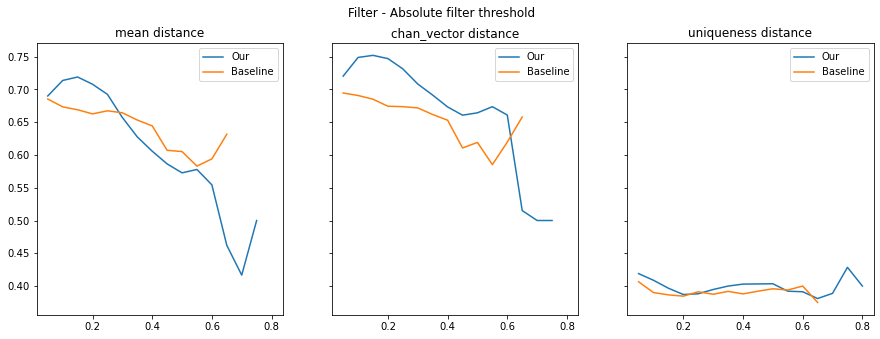

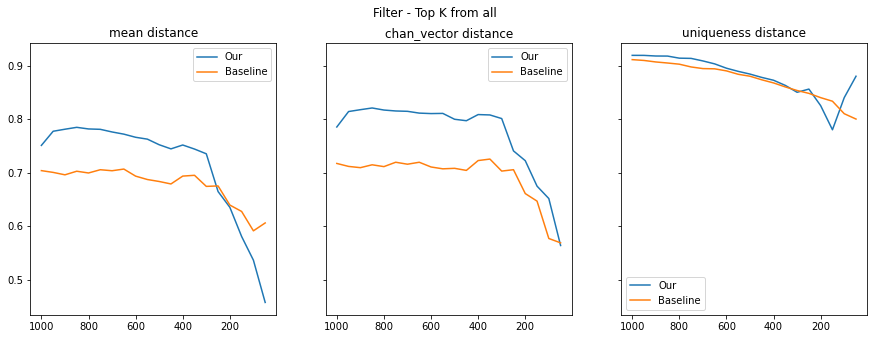

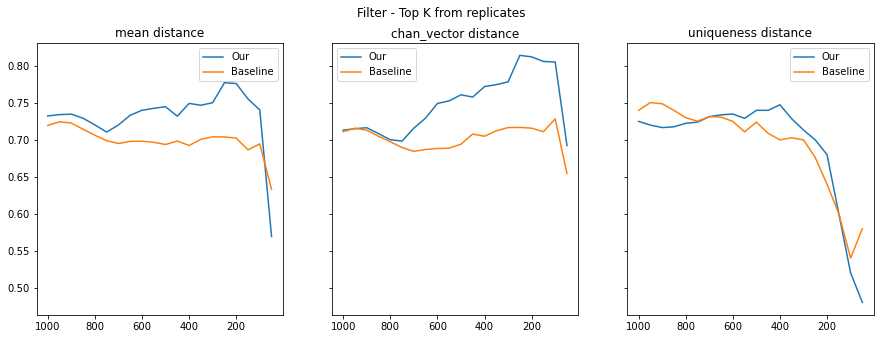

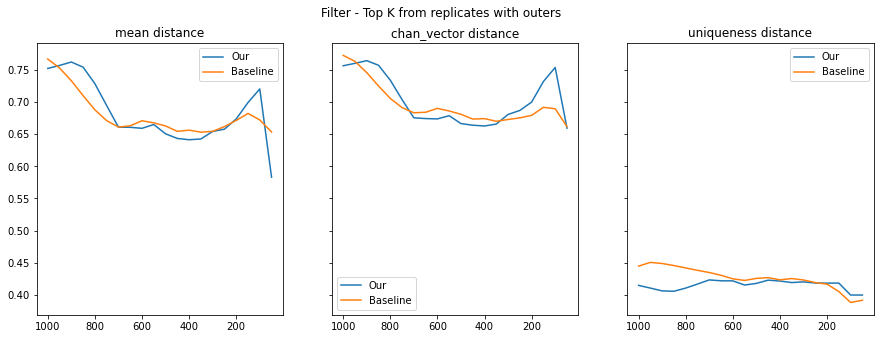

In [12]:
name_dict = {
    'abs': 'Absolute filter threshold',
    'topk': 'Top K from all',
    'topkfdup': 'Top K from replicates', 
    'topkfdupwmch': 'Top K from replicates with outers'
}

for filter_type in ['abs', 'topk','topkfdup', 'topkfdupwmch']:
    fig, ax = plt.subplots(ncols=3, figsize=(3*5,5), sharey=True, sharex=True)
    fig.suptitle(f'Filter - {name_dict[filter_type]}')
    
    for i, metric in enumerate(['mean', 'chan_vector', 'uniqueness']):
        ax[i].set_title(f'{metric} distance')
        
        for method in ['map', 'raw']:
            if metric in res[method][filter_type].keys():
                x, y = zip(*res[method][filter_type][metric])
                ax[i].plot(x, y)
    
        if 'topk' in filter_type:
            ax[i].invert_xaxis()
        ax[i].legend(['Our', 'Baseline'])

In [27]:
res = joblib.load('/home/naorko/res_dict.sav')

In [28]:
res.keys()

dict_keys(['map', 'raw'])

In [39]:
for k1, v1 in res.items():
    print(k1)
#     print('\t', v1.keys())
    for k2, v2 in v1.items():
        print('\t', k2)
#         print('\t', '\t', list(v2.keys()))
        for k3, v3 in v2.items():
            print('\t', '\t', k3)
            print('\t', '\t',  '\t', list(zip(*v3))[0])

map
	 abs
	 	 mean
	 	 	 (0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8)
	 	 chan_vector
	 	 	 (0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8)
	 	 uniqueness
	 	 	 (0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8)
	 topk
	 	 mean
	 	 	 (50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000)
	 	 chan_vector
	 	 	 (50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000)
	 	 uniqueness
	 	 	 (50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000)
raw
	 abs
	 	 mean
	 	 	 (0.05, 0

## Filter top K real threshold

In [23]:
filter_dict = {
    'topk': TopKFilterStrategy,
    'topkfdup': TopKFromDupFilterStrategy,
    'topkfdupwmch': TopKFromDupWithMatchFilterStrategy
}

filter_ths = dict()
for f_name, f_cls in filter_dict.items():
    filter_ths[f_name] = dict()
    for method in ['map', 'raw']:
        filter_ths[f_name][method] = []
        cur = joined.filter(regex=f'_{method}$')
        
        for topk_filter in tqdm(range(50, 1001, 50)):
            f = f_cls(topk_filter)
            _ = f.filter_dataframe(cur, f'ALL_{method}')
            th = f.get_filter_threshold()
            filter_ths[f_name][method].append((topk_filter, th))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

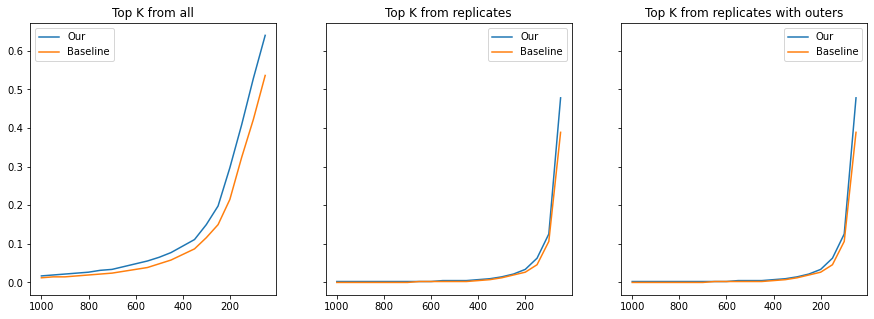

In [24]:
name_dict = {
    'topk': 'Top K from all',
    'topkfdup': 'Top K from replicates', 
    'topkfdupwmch': 'Top K from replicates with outers'
}

fig, ax = plt.subplots(ncols=3, figsize=(3*5,5), sharey=True, sharex=True)

for i, (f_name, f_full_name) in enumerate(name_dict.items()):
    ax[i].set_title(f_full_name)
        
    for method in ['map', 'raw']:
        x, y = zip(*filter_ths[f_name][method])
        ax[i].plot(x, y)

    ax[i].invert_xaxis()
    ax[i].legend(['Our', 'Baseline'])

In [22]:
method = 'raw'
joined.filter(regex=f'_{method}$').columns

Index(['AGP_raw', 'DNA_raw', 'ER_raw', 'Mito_raw', 'RNA_raw', 'ALL_raw'], dtype='object')

In [ ]:
import os
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)